# Exploring UV extinction curves

## Learning Goals

By the end of this turorial, you will be able to:

- Understand what a UV extinction curve is and how it is used to study dust properties
- Create your own UV extinction curve
- Learn how to parametrize a curve based on your UV extinction curve
- Learn how to do Python functions
- Discover the difference in the trend for curves corresponding to the Small and Large Magellanic Clouds (LMC and SMC)

## Introduction

**Extinction curve background**: An extinction curve represents the wavelength dependence of dust extinction. It compares the inherent Spectral Energy Distribution (SED) (~dust-free) of a star to the observed SED affected by dust extinction. Normally these curves are created by representing $k(\lambda-V)$ versus $1/\lambda$, with $\lambda$ being wavelength and $k(\lambda-V)$:

   $k(\lambda-V)$ = $\frac{E(\lambda-V)}{E(B-V)}$ = $\frac{m(\lambda-V)-m(\lambda-V)_o}{(B-V)-(B-V)_o}$ = $\frac{A(\lambda)-A(V)}{A(B)-A(V)}$

With the $x_o$ terms refering to the star that is nearly unaffected by dust. In order to perform this comparison, the stars should have the same spectral type. 

**Defining some terms**:

- **Color index**: difference between magnitude of a star in 2 different passbands, typically B and V. Symbol: $(B-V)$.
- **Extinction**: measure of interstellar reddening quantified by the difference in magnitudes. Symbol: $A_\lambda$.
- **Spectral type**: stellar classification from hotter (O stars) to cooler (M stars). Temperature defines a star's "color" and surface brightness.
- **FITS file**: Flexible Image Transport System. File often used in astronomy to store images and tables.

## Imports 

The first step will be to import the libraries we will be using throughout this tutorial: 

- _Observations_ from _astroquery.mast_ to query the Barbara A. Mikulski Archive for Space Telescopes (MAST).
- _Simbad_ from _astroquery.simbad_ to query the SIMBAD astronomical database.
- _fits_ from _astropy.io_ for accessing FITS files
- _matplotlib.pyplot_ for plotting data
- _numpy_ for array manipulations
- _curve_fit_ from scipy.optimize for data-fitting

In [42]:
from astroquery.mast import Observations
from astroquery.simbad import Simbad
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

**Warning**: If you have not installed the astroquery package in your computer, you may need to. Information about astroquery can be found <a href="https://astroquery.readthedocs.io/en/latest/">here</a>.

## Main content

### Loading data

The next step is to find the data file we will use. This is similar to searching through the <a href="https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html">MAST portal</a> since we will be using specific keywords to find the file. The target name of the first star we will be studying is AzV 214 (observation ID: swp22372), collected by International Ultraviolet Explorer (IUE). This will be the reddened star by dust. 

In [2]:
IUEobs = Observations.query_criteria(obs_collection="IUE", obs_id="swp22372")
data_products = Observations.get_product_list(IUEobs)
yourProd = Observations.filter_products(data_products, extension='swp22372mxlo_vo.fits')

yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str3,str8,str8,str56,str1,str62,str9,str28,str56,str1,str1,str1,str5,str20,int64,str6,str6,int64
318326,IUE,spectrum,swp22372,(extracted spectra/vo spectral container/SSAP) fits file,S,mast:IUE/url/pub/vospectra/iue2/swp22372mxlo_vo.fits,SCIENCE,Minimum Recommended Products,(extracted spectra/vo spectral container/SSAP) fits file,--,--,--,FM197,swp22372mxlo_vo.fits,48960,318326,PUBLIC,2


Now that we have the data file, we can download it using the information contained in the table shown above by doing:

In [3]:
Observations.download_products(yourProd, mrp_only = False, cache = False) 

Local Path,Status,Message,URL
str48,str8,object,object
./mastDownload/IUE/swp22372/swp22372mxlo_vo.fits,COMPLETE,None,None


If the download does not happen automatically, by clicking on the URL displayed above you will be able to download the file. In order to have a more complete image of our target, let's download a different observation for the same object, but in a different wavelength range, we can use the following observation ID: lwr17263 (this is still AzV 214).

In [4]:
IUEobs2 = Observations.query_criteria(obs_collection="IUE", obs_id="lwr17263")
data_products2 = Observations.get_product_list(IUEobs2)
yourProd2 = Observations.filter_products(data_products2, extension='lwr17263mxlo_vo.fits')
Observations.download_products(yourProd2, mrp_only = False, cache = False) 

Local Path,Status,Message,URL
str48,str8,object,object
./mastDownload/IUE/lwr17263/lwr17263mxlo_vo.fits,COMPLETE,None,None


Now let's do the same for the unreddened star. The target name of this star is AzV 380 (observation IDs: swp10319, lwr17265) and was also collected by IUE.

In [5]:
IUEobs3 = Observations.query_criteria(obs_collection="IUE", obs_id="swp10319")
data_products3 = Observations.get_product_list(IUEobs3)
yourProd3 = Observations.filter_products(data_products3, extension='swp10319mxlo_vo.fits')
Observations.download_products(yourProd3, mrp_only = False, cache = False) 

IUEobs4 = Observations.query_criteria(obs_collection="IUE", obs_id="lwr17265")
data_products4 = Observations.get_product_list(IUEobs4)
yourProd4 = Observations.filter_products(data_products4, extension='lwr17265mxlo_vo.fits')
Observations.download_products(yourProd4, mrp_only = False, cache = False) 

Local Path,Status,Message,URL
str48,str8,object,object
./mastDownload/IUE/lwr17265/lwr17265mxlo_vo.fits,COMPLETE,None,None


Again, if the download does not happen automatically, by clicking on the URLs displayed above, you will be able to download the necessary data to continue this tutorial.

### File information

Now, let's explore the FITS file that we got for the reddened star.

In [29]:
filename = "./mastDownload/IUE/swp22372/swp22372mxlo_vo.fits"
fits.info(filename)

Filename: ./mastDownload/IUE/swp22372/swp22372mxlo_vo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     350   ()      
  1  Spectral Container    1 BinTableHDU    141   1R x 4C   [495E, 495E, 495E, 495I]   


- **No. 0 (PRIMARY)**: This HDU contains meta-data related to the entire file.
- **No. 1 (Spectral Container)**: This HDU contains the spectral profile of the target as a function of wavelength.

The header of the file contains additional information about the data, such as the wavelength reference frame or the reference equinox. It can be accessed in the following way (only some part of the information contained in the header is printed in this section, the user is encouraged to print the complete header if they are interested to see the whole information contained in it).

In [30]:
with fits.open(filename) as hdulist: 
    header1 = hdulist[1].header

print(repr(header1[54:61]))

EQUINOX =              2000.00 /                                                
RADECSYS= 'FK4'                /                                                
TIMESYS = 'UTC'                / Time system                                    
MJDREF  =              0.00000 / [d] MJD zero point for times                   
SPECSYS = 'TOPOCENT'           / wavelength reference frame                     
VOCLASS = 'SPECTRUM V1.0'      / VO Data Model                                  
VOSEGT  = 'SPECTRUM'           / Segment type                                   


The data contained in this fits failed can be accessed as shown below:

In [31]:
with fits.open(filename) as hdulist:
    data0 = hdulist[1].data

wav = data0[0][0] # angstrom, A
flux = data0[0][1] # ergs/cm2/sec/A

Let's do the same for the other files and plot the logarithm of their flux versus the inverse of the wavelength, as it is normally done in this type of studies.

<ipython-input-32-20c407ebc50e>:31: RuntimeWarning: invalid value encountered in log10
  plt.plot(wavinv2,np.log10(flux2),'r:',label='lwr17263')
<ipython-input-32-20c407ebc50e>:34: RuntimeWarning: invalid value encountered in log10
  plt.plot(wavinv4,np.log10(flux4),'b:',label='lwr17265')


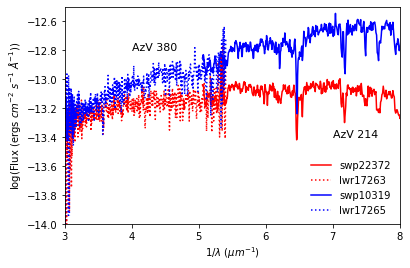

In [32]:
filename2 = "./mastDownload/IUE/lwr17263/lwr17263mxlo_vo.fits"
with fits.open(filename2) as hdulist:
    data2 = hdulist[1].data

wav2 = data2[0][0] # A
flux2 = data2[0][1] # ergs/cm2/sec/A

filename3 = "./mastDownload/IUE/swp10319/swp10319mxlo_vo.fits"
with fits.open(filename3) as hdulist:
    data3 = hdulist[1].data

wav3 = data3[0][0] # A
flux3 = data3[0][1] # ergs/cm2/sec/A

filename4 = "./mastDownload/IUE/lwr17265/lwr17265mxlo_vo.fits"
with fits.open(filename4) as hdulist:
    data4 = hdulist[1].data

wav4 = data4[0][0] # A
flux4 = data4[0][1] # ergs/cm2/sec/A

wavinv = 1/(wav*1e-4) # mu-m ^-1
wavinv2 = 1/(wav2*1e-4) # mu-m ^-1
wavinv3 = 1/(wav3*1e-4) # mu-m ^-1
wavinv4 = 1/(wav4*1e-4) # mu-m ^-1

fig = plt.figure()
ax = plt.subplot(111)

plt.plot(wavinv,np.log10(flux),'r',label='swp22372')
plt.plot(wavinv2,np.log10(flux2),'r:',label='lwr17263')
plt.text(4, -12.8,'AzV 380', fontsize = 11)
plt.plot(wavinv3,np.log10(flux3),'b',label='swp10319')
plt.plot(wavinv4,np.log10(flux4),'b:',label='lwr17265')
plt.text(7, -13.4, 'AzV 214', fontsize = 11)

ax.set_xlabel('1/$\lambda$ ($\mu m^{-1}$)')
ax.set_ylabel(r'log(Flux (ergs $cm^{-2}$ $s^{-1}$ $\AA^{-1}$))')
ax.set_xlim([3, 8])
ax.set_ylim([-14, -12.5])

plt.legend(loc='best',frameon=False)

plt.show()

**Heads-up**: when plotting the figure, you may get some warning messages, this are normal and do not mean you are doing it wrong, python may have just run into some non-logarithm friendly values, but we can still work with this data!

Let's now use <a href="http://simbad.cds.unistra.fr/simbad/">SIMBAD</a> database to look for the fluxes in the B and V bands for both stars. We can do a simple query using the identifier of both stars. The magnitudes can be found under the 8th subgroup presented below the name of the stars, called 'Fluxes', since SIMBAD can provide you with either the flux or the magnitude of the star in those bands.

- AzV 214: $m_V = 13.39$, $m_B = 13.40$.
- AzV 380: $m_V = 13.53$, $m_B = 13.43$.

From these values we can directly calculate the value of $E(B-V) = (B-V)-(B-V)_o$. In order to do this using Python we can do the following, first add the fields for the query that we want, namely _flux(B)_ and _flux(V)_:

In [33]:
Simbad.add_votable_fields('flux(B)','flux(V)')
table1 = Simbad.query_object('AzV 214')
table1

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,FLUX_B_1,FLUX_V_1,FLUX_B_2,FLUX_V_2,FLUX_B_3,FLUX_V_3,FLUX_B_4,FLUX_V_4,FLUX_B_5,FLUX_V_5,FLUX_B_6,FLUX_V_6,FLUX_B_7,FLUX_V_7,FLUX_B_8,FLUX_V_8,FLUX_B_9,FLUX_V_9,FLUX_B_10,FLUX_V_10,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
AzV 214,00 58 54.7802,-72 13 17.172,14,14,0.014,0.012,90,A,O,2020yCat.1350....0G,13.4,13.39,13.4,13.39,13.4,13.39,13.4,13.39,13.4,13.39,13.4,13.39,13.4,13.39,13.4,13.39,13.4,13.39,13.4,13.39,13.4,13.39,1


In [34]:
table2 = Simbad.query_object('AzV 380')
table2

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,FLUX_B_1,FLUX_V_1,FLUX_B_2,FLUX_V_2,FLUX_B_3,FLUX_V_3,FLUX_B_4,FLUX_V_4,FLUX_B_5,FLUX_V_5,FLUX_B_6,FLUX_V_6,FLUX_B_7,FLUX_V_7,FLUX_B_8,FLUX_V_8,FLUX_B_9,FLUX_V_9,FLUX_B_10,FLUX_V_10,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SK 120,01 05 24.7610,-73 03 52.973,14,14,0.019,0.019,90,A,O,2020yCat.1350....0G,13.43,13.53,13.43,13.53,13.43,13.53,13.43,13.53,13.43,13.53,13.43,13.53,13.43,13.53,13.43,13.53,13.43,13.53,13.43,13.53,13.43,13.53,1


In [35]:
V_214 = float(table1['FLUX_V'])
B_214 = float(table1['FLUX_B'])

V_380 = float(table2['FLUX_V'])
B_380 = float(table2['FLUX_B'])

E_B_V = (B_214-V_214)-(B_380-V_380)

print("The value of E(B-V) is equal to",E_B_V)

The value of E(B-V) is equal to 0.10999870300292969


So finally, let's plot the extinction curve!

<ipython-input-36-e1c79d809264>:3: RuntimeWarning: invalid value encountered in log
  plt.plot(wavinv4,np.abs((np.log(flux2/flux4)-np.log(V_214/V_380))/E_B_V),'o',markersize=2)


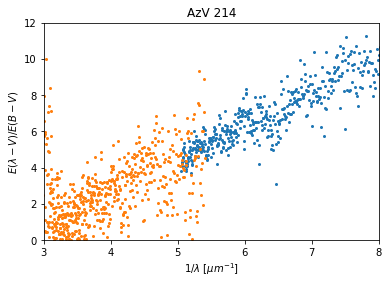

In [36]:
plt.figure()
plt.plot(wavinv,np.abs((np.log(flux/flux3)-np.log(V_214/V_380))/E_B_V),'o',markersize=2)
plt.plot(wavinv4,np.abs((np.log(flux2/flux4)-np.log(V_214/V_380))/E_B_V),'o',markersize=2)
plt.xlim([3,8])
plt.ylim([0,12])
plt.xlabel(r'$1/\lambda$ $[\mu m^{-1}]$')
plt.ylabel(r'$E(\lambda-V)/E(B-V)$')
plt.title('AzV 214')
plt.show()

This is the typical shape encountered for extinction curves corresponding to the Small Magellanic Cloud (SMC), as can be seen in this <a href="https://arxiv.org/pdf/astro-ph/0305257.pdf">article</a>. 

Now that we have the curve, we can parametrize it! First let's combine the arrays we have into one unique 1D vector and take-out the problematic values:

In [82]:
wvinv = np.concatenate((wavinv4,wavinv))
k_lam_V = np.concatenate((np.abs((np.log(flux2/flux4)-np.log(V_214/V_380))/E_B_V),np.abs((np.log(flux/flux3)-np.log(V_214/V_380))/E_B_V)))

prob = np.where(np.isnan(k_lam_V))[0]

wvinv[prob] = 0
k_lam_V[prob] = 0

<ipython-input-82-e5a4f881536f>:2: RuntimeWarning: invalid value encountered in log
  k_lam_V = np.concatenate((np.abs((np.log(flux2/flux4)-np.log(V_214/V_380))/E_B_V),np.abs((np.log(flux/flux3)-np.log(V_214/V_380))/E_B_V)))


Let's create the x-vector that we will use for the data-fitting, _$x = 1/\lambda$_, using _np.linspace_ (if you are not familiarized with linspace, information about it can be found <a href="https://numpy.org/doc/stable/reference/generated/numpy.linspace.html">here</a>):

In [79]:
n = 1000
x_wavinv = np.linspace(3,8,n)

Now, let's parametrize the curve according to the FM parametrization as presented in
<a href="https://ui.adsabs.harvard.edu/abs/1990ApJS...72..163F/abstract">Fitzpatrick and Massa 1990</a>. Fist, let's create the function with the suggested structure of the article. A function in Python is defined starting with the word def, then the name of your function, inside the parenthesis the inputs are defined, and the output of said function is whatever follows the word _return_. More information on Python functions can be found <a href="https://www.datacamp.com/tutorial/functions-python-tutorial">here</a>.

In [88]:
def FMpar(x, C1, C2, C3, C4, xo, gamma):

    F = np.zeros(len(x))
    for i in range(len(x)):
        if x[i] >= 5.9:
            F = 0.5392*(x-5.9)**2+0.05644*(x-5.9)**3
        
    D = x**2/((x**2-xo**2)**2+x**2*gamma**2)
    
    k = C1 + C2*x + C3*D + C4*F
    
    return k

/Users/clarapueerto/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-94-3aa212ea797b>:9: RuntimeWarning: invalid value encountered in log
  plt.plot(wavinv4,np.abs((np.log(flux2/flux4)-np.log(V_214/V_380))/E_B_V),'o',markersize=2)


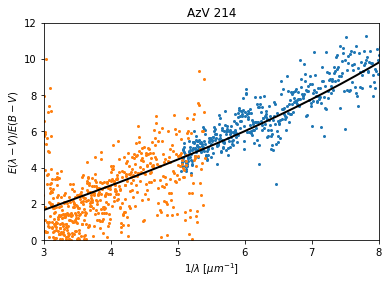

In [94]:
parameters, covariance = curve_fit(FMpar, wvinv, k_lam_V)

F = 0.5392*(x_wavinv-5.9)**2+0.05644*(x_wavinv-5.9)**3
D = x_wavinv**2/((x_wavinv**2-parameters[4]**2)**2+x_wavinv**2*parameters[5]**2)
k = parameters[0] + parameters[1]*x_wavinv + parameters[2]*D + parameters[3]*F

plt.figure()
plt.plot(wavinv,np.abs((np.log(flux/flux3)-np.log(V_214/V_380))/E_B_V),'o',markersize=2)
plt.plot(wavinv4,np.abs((np.log(flux2/flux4)-np.log(V_214/V_380))/E_B_V),'o',markersize=2)
plt.plot(x_wavinv,k,'k',linewidth=2)
plt.xlim([3,8])
plt.ylim([0,12])
plt.xlabel(r'$1/\lambda$ $[\mu m^{-1}]$')
plt.ylabel(r'$E(\lambda-V)/E(B-V)$')
plt.title('AzV 214')
plt.show()

## Exercises

Now you can try to do it yourself! Try to obtain the extinction curve of a Large Magellanic Cloud (LMC) following the steps presented for the SMC one and look for the differences in the trend between the two.

### Load the data

The targets for this exercise will be:

- Sk -69 206 (Observation IDs: swp36552,lwp15751) (reddened star)
- Sk -67 5 (Observation IDs: swp04827,lwr04170) (unreddened star)

First, do the database search for the reddened star:

In [12]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
IUEobs = Observations.query_criteria(obs_collection="IUE", obs_id="swp36552")
data_products = Observations.get_product_list(IUEobs)
yourProd = Observations.filter_products(data_products, extension="swp36552mxlo_vo.fits")

yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str3,str8,str8,str56,str1,str62,str9,str28,str56,str1,str1,str1,str5,str20,int64,str6,str6,int64
327806,IUE,spectrum,swp36552,(extracted spectra/vo spectral container/SSAP) fits file,S,mast:IUE/url/pub/vospectra/iue2/swp36552mxlo_vo.fits,SCIENCE,Minimum Recommended Products,(extracted spectra/vo spectral container/SSAP) fits file,--,--,--,OBLCG,swp36552mxlo_vo.fits,48960,327806,PUBLIC,2


Now, download the data as before:

In [13]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
Observations.download_products(yourProd, mrp_only = False, cache = False) 

Local Path,Status,Message,URL
str48,str8,object,object
./mastDownload/IUE/swp36552/swp36552mxlo_vo.fits,COMPLETE,None,None


And again, in order to cover a wider wavelength range, let's also download the other part of the spectra using the second observation ID provided:

In [14]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
IUEobs2 = Observations.query_criteria(obs_collection="IUE", obs_id="lwp15751")
data_products2 = Observations.get_product_list(IUEobs2)
yourProd2 = Observations.filter_products(data_products2, extension="lwp15751mxlo_vo.fits")
Observations.download_products(yourProd2, mrp_only = False, cache = False) 

Local Path,Status,Message,URL
str48,str8,object,object
./mastDownload/IUE/lwp15751/lwp15751mxlo_vo.fits,COMPLETE,None,None


Now, let's do the same for the unreddened star:

In [15]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
IUEobs3 = Observations.query_criteria(obs_collection="IUE", obs_id="swp04827")
data_products3 = Observations.get_product_list(IUEobs3)
yourProd3 = Observations.filter_products(data_products3, extension="swp04827mxlo_vo.fits")
Observations.download_products(yourProd3, mrp_only = False, cache = False) 

Local Path,Status,Message,URL
str48,str8,object,object
./mastDownload/IUE/swp04827/swp04827mxlo_vo.fits,COMPLETE,None,None


In [16]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
IUEobs4 = Observations.query_criteria(obs_collection="IUE", obs_id="lwr04170")
data_products4 = Observations.get_product_list(IUEobs4)
yourProd4 = Observations.filter_products(data_products4, extension="lwr04170mxlo_vo.fits")
Observations.download_products(yourProd4, mrp_only = False, cache = False) 

Local Path,Status,Message,URL
str48,str8,object,object
./mastDownload/IUE/lwr04170/lwr04170mxlo_vo.fits,COMPLETE,None,None


### Open the fits file, explore it and save the data

In [96]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
filename = "./mastDownload/IUE/swp36552/swp36552mxlo_vo.fits"
fits.info(filename)

with fits.open(filename) as hdulist:
    data1 = hdulist[1].data

wav = data1[0][0] # A
flux = data1[0][1] # ergs/cm2/sec/A

wavinv = 1/(wav*1e-4) # mu-m

filename2 = "./mastDownload/IUE/lwp15751/lwp15751mxlo_vo.fits"
fits.info(filename2)

with fits.open(filename2) as hdulist:
    data2 = hdulist[1].data

wav2 = data2[0][0] # A
flux2 = data2[0][1] # ergs/cm2/sec/A

wavinv2 = 1/(wav2*1e-4) # mu-m

filename3 = "./mastDownload/IUE/swp04827/swp04827mxlo_vo.fits"
fits.info(filename3)

with fits.open(filename3) as hdulist:
    data3 = hdulist[1].data

wav3 = data3[0][0] # A
flux3 = data3[0][1] # ergs/cm2/sec/A

wavinv3 = 1/(wav3*1e-4) # mu-m

filename4 = "./mastDownload/IUE/lwr04170/lwr04170mxlo_vo.fits"
fits.info(filename4)

with fits.open(filename4) as hdulist:
    data4 = hdulist[1].data

wav4 = data4[0][0] # A
flux4 = data4[0][1] # ergs/cm2/sec/A

wavinv4 = 1/(wav4*1e-4) # mu-m

Filename: ./mastDownload/IUE/swp36552/swp36552mxlo_vo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     351   ()      
  1  Spectral Container    1 BinTableHDU    141   1R x 4C   [495E, 495E, 495E, 495I]   
Filename: ./mastDownload/IUE/lwp15751/lwp15751mxlo_vo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     350   ()      
  1  Spectral Container    1 BinTableHDU    141   1R x 4C   [563E, 563E, 563E, 563I]   
Filename: ./mastDownload/IUE/swp04827/swp04827mxlo_vo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     345   ()      
  1  Spectral Container    1 BinTableHDU    141   1R x 4C   [495E, 495E, 495E, 495I]   
Filename: ./mastDownload/IUE/lwr04170/lwr04170mxlo_vo.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     353   ()      
  1  Spectral Container    1 BinTableHDU    141 

### Plot the spectra of both stars

<ipython-input-97-7d8a87fc0b93>:6: RuntimeWarning: invalid value encountered in log10
  plt.plot(wavinv2,np.log10(flux2),'r:',label='lwp15751')
<ipython-input-97-7d8a87fc0b93>:9: RuntimeWarning: invalid value encountered in log10
  plt.plot(wavinv4,np.log10(flux4),'b:',label='lwr04170')


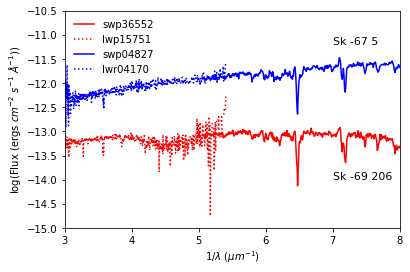

In [97]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
fig = plt.figure()
ax = plt.subplot(111)

plt.plot(wavinv,np.log10(flux),'r',label='swp36552')
plt.plot(wavinv2,np.log10(flux2),'r:',label='lwp15751')
plt.text(7, -14, 'Sk -69 206', fontsize = 11)
plt.plot(wavinv3,np.log10(flux3),'b',label='swp04827')
plt.plot(wavinv4,np.log10(flux4),'b:',label='lwr04170')
plt.text(7, -11.2, 'Sk -67 5', fontsize = 11)

ax.set_xlabel('1/$\lambda$ ($\mu m^{-1}$)')
ax.set_ylabel(r'log(Flux (ergs $cm^{-2}$ $s^{-1}$ $\AA^{-1}$))')
ax.set_xlim([3, 8])
ax.set_ylim([-15, -10.5])

plt.legend(loc='best',frameon=False)

plt.show()

### Find the values for the B and V bands in SIMBAD

In [95]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
table1 = Simbad.query_object('Sk -69 206')
table1

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,FLUX_B_1,FLUX_V_1,FLUX_B_2,FLUX_V_2,FLUX_B_3,FLUX_V_3,FLUX_B_4,FLUX_V_4,FLUX_B_5,FLUX_V_5,FLUX_B_6,FLUX_V_6,FLUX_B_7,FLUX_V_7,FLUX_B_8,FLUX_V_8,FLUX_B_9,FLUX_V_9,FLUX_B_10,FLUX_V_10,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SK -69 206,05 35 35.9718,-69 07 06.552,14,14,0.017,0.017,90,A,O,2020yCat.1350....0G,12.99,12.82,12.99,12.82,12.99,12.82,12.99,12.82,12.99,12.82,12.99,12.82,12.99,12.82,12.99,12.82,12.99,12.82,12.99,12.82,12.99,12.82,1


In [18]:
table2 = Simbad.query_object('Sk -67 5')
table2

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,FLUX_B,FLUX_V,FLUX_B_1,FLUX_V_1,FLUX_B_2,FLUX_V_2,FLUX_B_3,FLUX_V_3,FLUX_B_4,FLUX_V_4,FLUX_B_5,FLUX_V_5,FLUX_B_6,FLUX_V_6,FLUX_B_7,FLUX_V_7,FLUX_B_8,FLUX_V_8,FLUX_B_9,FLUX_V_9,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
HD 268605,04 50 18.9258,-67 39 38.036,14,14,0.027,0.027,90,A,O,2020yCat.1350....0G,11.2,11.377,11.2,11.377,11.2,11.377,11.2,11.377,11.2,11.377,11.2,11.377,11.2,11.377,11.2,11.377,11.2,11.377,11.2,11.377,1


In [98]:
V_69_206 = float(table1['FLUX_V'])
B_69_206 = float(table1['FLUX_B'])

V_67_5 = float(table2['FLUX_V'])
B_67_5 = float(table2['FLUX_B'])

E_B_V = (B_69_206-V_69_206)-(B_67_5-V_67_5)

print("The value of E(B-V) is equal to",E_B_V)

The value of E(B-V) is equal to 0.26999950408935547


### Create the extinction curve

<ipython-input-100-a17bca57e47f>:4: RuntimeWarning: invalid value encountered in log
  plt.plot(wavinv2,np.abs((np.log(flux2/flux4)-np.log(V_69_206/V_67_5))/E_B_V),'o',markersize=2)


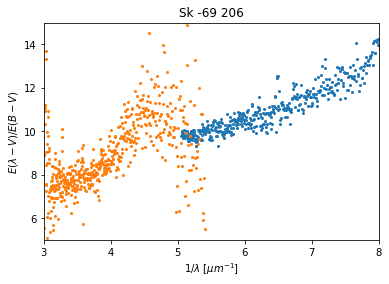

In [100]:
# You can copy, paste and modify the code corresponding to this part that we used for the SMC cloud here
plt.figure()
plt.plot(wavinv,np.abs((np.log(flux/flux3)-np.log(V_69_206/V_67_5))/E_B_V),'o',markersize=2)
plt.plot(wavinv2,np.abs((np.log(flux2/flux4)-np.log(V_69_206/V_67_5))/E_B_V),'o',markersize=2)
plt.xlim([3,8])
plt.ylim([5,15])
plt.xlabel(r'$1/\lambda$ $[\mu m^{-1}]$')
plt.ylabel(r'$E(\lambda-V)/E(B-V)$')
plt.title('Sk -69 206')
plt.show()

### Parametrize the curve 

<ipython-input-102-d7cf5ea0918e>:2: RuntimeWarning: invalid value encountered in log
  k_lam_V2 = np.concatenate((np.abs((np.log(flux2/flux4)-np.log(V_69_206/V_67_5))/E_B_V),np.abs((np.log(flux/flux3)-np.log(V_69_206/V_67_5))/E_B_V)))
/Users/clarapueerto/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-102-d7cf5ea0918e>:17: RuntimeWarning: invalid value encountered in log
  plt.plot(wavinv2,np.abs((np.log(flux2/flux4)-np.log(V_69_206/V_67_5))/E_B_V),'o',markersize=2)


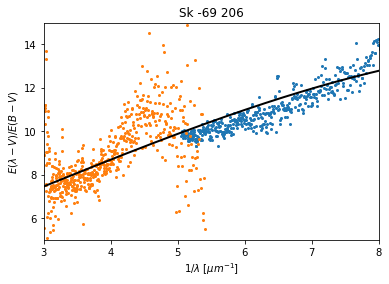

In [102]:
wvinv2 = np.concatenate((wavinv2,wavinv))
k_lam_V2 = np.concatenate((np.abs((np.log(flux2/flux4)-np.log(V_69_206/V_67_5))/E_B_V),np.abs((np.log(flux/flux3)-np.log(V_69_206/V_67_5))/E_B_V)))

prob = np.where(np.isnan(k_lam_V2))[0]

wvinv2[prob] = 0
k_lam_V2[prob] = 0

parameters, covariance = curve_fit(FMpar, wvinv2, k_lam_V2)

F = 0.5392*(x_wavinv-5.9)**2+0.05644*(x_wavinv-5.9)**3
D = x_wavinv**2/((x_wavinv**2-parameters[4]**2)**2+x_wavinv**2*parameters[5]**2)
k = parameters[0] + parameters[1]*x_wavinv + parameters[2]*D + parameters[3]*F

plt.figure()
plt.plot(wavinv,np.abs((np.log(flux/flux3)-np.log(V_69_206/V_67_5))/E_B_V),'o',markersize=2)
plt.plot(wavinv2,np.abs((np.log(flux2/flux4)-np.log(V_69_206/V_67_5))/E_B_V),'o',markersize=2)
plt.plot(x_wavinv,k,'k',linewidth=2)
plt.xlim([3,8])
plt.ylim([5,15])
plt.xlabel(r'$1/\lambda$ $[\mu m^{-1}]$')
plt.ylabel(r'$E(\lambda-V)/E(B-V)$')
plt.title('Sk -69 206')
plt.show()

Can you see the difference in the trend followed by the extinction curve between this case (LMC) and the one before (SMC)? More information about the different trends can be found in the following <a href="https://arxiv.org/pdf/astro-ph/0305257.pdf">article</a>.

## Additional Resources

For more information about the MAST archive and details about mission data: 

<a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
<a href="https://archive.stsci.edu/iue/">International Ultraviolet Explorer Page (MAST)</a> <br>
<a href="https://archive.stsci.edu/iue/mdr_help.html">IUE Data Retrieval Help Page</a> 

For more information about extinction curves:


<a href="https://ui.adsabs.harvard.edu/abs/2003ApJ...594..279G/abstract">A quantitative comparison of SMC, LMC and Milky Way UV to NIR extinction curves</a> <br>

## About this Notebook

**Author**: Clara Puerto Sánchez, ScienceBetter consultant <br>
**Updated on**: 27/06/2022

## Citations

If you use `astropy`, `numpy` or `scipy` for published research, please cite the
authors. Follow these links for more information about citing them:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `scipy`](https://scipy.org/citing-scipy/)

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>